In [1]:
import os
ROOT_DIR = "/home/nrr/projects/inundation-emulator"
os.chdir(ROOT_DIR)

In [2]:
from netCDF4 import Dataset
from collections import namedtuple
import random
from collections.abc import Generator
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-04-10 07:47:17.409231: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 07:47:17.411191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 07:47:17.415041: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 07:47:17.426157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744271237.445133 3850460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744271237.45

In [3]:
DATA_DIR = '/home/nrr/NGI/P/2022/02/20220296/Calculations/temp_emulator'
TOPOFILE = '/home/ebr/data/PTHA2020_runs_UMA/Catania/C_CT.grd'
TOPO_MASK = '/home/ebr/data/PTHA2020_runs_UMA/Catania/ct_mask.npy'
SCENARIOS = "/home/nrr/projects/inundation-emulator/scenario.txt"
GRID_INFO_FILE = '/home/ebr/data/PTHA2020_runs_UMA/Catania/grid_info.json'
#GENERATED_DIR = os.path.join(ROOT_DIR, 'generated')
#SUMMARIES_TRAIN = os.path.join(DATA_DIR, 'train_test/train.txt')
#SUMMARIES_VAL = os.path.join(DATA_DIR, 'train_test/validate.txt')

In [ ]:
from src.data_reader import DataReader

pois = range(30,45)
n_pois = len(pois)

reader = DataReader(
    rundir=DATA_DIR,
    scenarios_file=SCENARIOS,
    pois=pois,
    datadir=DATA_DIR,
    # topofile=TOPOFILE,
    # topomask_file=TOPO_MASK,
    shuffle_on_load=False,
    reload=False
)

TypeError: DataReader.__init__() missing 1 required positional argument: 'rundir'

In [ ]:
reader.store_grid_info(GRID_INFO_FILE)

In [5]:
import json

with open('/home/ebr/data/PTHA2020_runs_UMA/Catania/grid_info.json') as f:
    grid_info = json.load(f)

In [6]:
grid_info

{'dimensions': {'lon': 912,
  'lat': 2224,
  'grid_lon': 912,
  'grid_lat': 2224,
  'time': 2},
 'variables': {'grid_lat': {'dimensions': ['grid_lat'],
   'datatype': 'float64',
   'attributes': {'long_name': 'Grid latitude', 'units': 'degrees'},
   'data': [37.310341551192096,
    37.31043164617629,
    37.310521741160485,
    37.31061183614469,
    37.31070193112888,
    37.31079202611308,
    37.31088212109727,
    37.31097221608147,
    37.31106231106566,
    37.311152406049864,
    37.31124250103406,
    37.311332596018254,
    37.31142269100245,
    37.31151278598664,
    37.31160288097084,
    37.31169297595504,
    37.311783070939235,
    37.31187316592343,
    37.311963260907625,
    37.31205335589182,
    37.312143450876015,
    37.31223354586022,
    37.31232364084441,
    37.312413735828606,
    37.3125038308128,
    37.312593925796996,
    37.3126840207812,
    37.31277411576539,
    37.31286421074959,
    37.31295430573378,
    37.31304440071798,
    37.31313449570217,
  

In [7]:
grid_info['dimensions']['grid_lon']

912

In [8]:
np.zeros(10)[range(1,5)]

array([0., 0., 0., 0.])

In [ ]:

dataset = tf.data.Dataset.from_generator(
        generator=reader.generator,
        output_signature=(
                tf.TensorSpec(shape=(n_pois,481), dtype=tf.int32),
                tf.TensorSpec(shape=(reader.topo_mask.sum()), dtype=tf.int32)
        )
)

In [ ]:
for i,element in enumerate(dataset):
    print(i)

In [ ]:
# Batch the dataset
batch_size = 30
batched_dataset = dataset.batch(batch_size)

# Iterate over the batched dataset and print the results
for i, batch in enumerate(batched_dataset):
    eta, flow_depth = batch
    print(i, flow_depth.shape)
    

# Inspect netcdf files.

In [ ]:
from pprint import pprint

def inspect_nc_file(file_path):
    # Open the NetCDF file
    dataset = Dataset(file_path, 'r')
    
    # Print general information about the dataset
    print(f"File: {file_path}")
    print(f"Dimensions:")
    pprint(dataset.dimensions)
    
    print(f"\nVariables:")
    pprint(dataset.variables)
    
    print(f"\nGlobal Attributes:")
    pprint(dataset.ncattrs())
    for attr in dataset.ncattrs():
        print(f"{attr}: {getattr(dataset, attr)}")
    
    # Close the dataset
    dataset.close()

# Example usage
file_path = '/home/ebr/data/PTHA2020_runs_UMA/train_164/1357_E02020N3739E02658N3366-PS-Mur_PYes_Var-M895_E02426N3465_S002_CT_10m.nc'
#file_path = '/home/ebr/data/PTHA2020_runs_UMA/train_164/1357_E02020N3739E02658N3366-PS-Mur_PYes_Var-M895_E02426N3465_S002_ts.nc'
#file_path = "/home/ebr/data/PTHA2020_runs_UMA/Catania/C_CT.grd"
inspect_nc_file(file_path)

File: /home/ebr/data/PTHA2020_runs_UMA/train_164/1357_E02020N3739E02658N3366-PS-Mur_PYes_Var-M895_E02426N3465_S002_CT_10m.nc
Dimensions:
{'grid_lat': "<class 'netCDF4.Dimension'>": name = 'grid_lat', size = 2224,
 'grid_lon': "<class 'netCDF4.Dimension'>": name = 'grid_lon', size = 912,
 'lat': "<class 'netCDF4.Dimension'>": name = 'lat', size = 2224,
 'lon': "<class 'netCDF4.Dimension'>": name = 'lon', size = 912,
 'time': "<class 'netCDF4.Dimension'>" (unlimited): name = 'time', size = 2}

Variables:
{'deformation': <class 'netCDF4.Variable'>
int16 deformation(grid_lat, grid_lon)
    scale_factor: 0.0015259022
    add_offset: 0.0007629511
    long_name: Deformation of the bathymetry
    standard_name: deformation
    units: meters
    missing_value: 32767
    _FillValue: 32767
unlimited dimensions: 
current shape = (2224, 912)
filling on,
 'grid_lat': <class 'netCDF4.Variable'>
float64 grid_lat(grid_lat)
    long_name: Grid latitude
    units: degrees
unlimited dimensions: 
current s

In [10]:
ds = Dataset(file_path, 'r')
ds_topo = Dataset("/home/ebr/data/PTHA2020_runs_UMA/Catania/C_CT.grd")

In [11]:
max_height = ds.variables["max_height"]
max_height.set_auto_maskandscale(True)
deformation = ds.variables["deformation"]
deformation.set_auto_maskandscale(True)
topography = ds_topo.variables["z"]


In [12]:
topography[:,:]

masked_array(
  data=[[ 15.0376 ,  14.2821 ,  14.2897 , ...,  -2.76276,  -2.79932,
          -2.82395],
        [ 14.4699 ,  14.2657 ,  14.2704 , ...,  -2.98629,  -3.02242,
          -3.04324],
        [ 14.2738 ,  13.9703 ,  13.9513 , ...,  -3.28626,  -3.32632,
          -3.34834],
        ...,
        [155.921  , 155.831  , 155.709  , ..., -65.9731 , -66.1821 ,
         -66.3768 ],
        [155.852  , 155.779  , 155.597  , ..., -66.0507 , -66.2616 ,
         -66.4558 ],
        [155.748  , 155.678  , 155.486  , ..., -66.105  , -66.3188 ,
         -66.5128 ]],
  mask=False,
  fill_value=np.float64(1e+20),
  dtype=float32)

In [13]:

deformed_topography = topography[:,:] - deformation[:,:].data


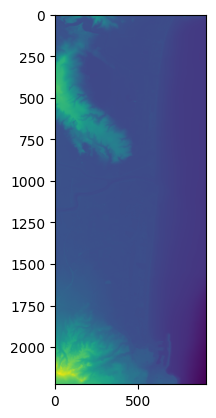

In [14]:
plt.imshow(deformed_topography)

In [ ]:
# Create a mask and calculate flow_depth
mask = np.logical_and(topography[:,:] > 0, ~max_height[:,:].mask, max_height[:,:] > deformed_topography)

In [ ]:
!pwd

/home/nrr/projects/inundation-emulator


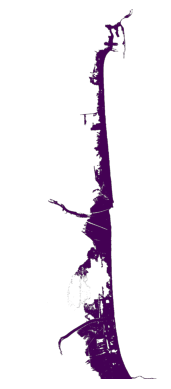

In [30]:
plt.imshow(mask)
plt.gca().invert_yaxis()
plt.axis('off')
plt.savefig("mask.png", dpi=100, bbox_inches='tight', transparent=True)


In [26]:
#where False set to nan
mask = np.where(mask, 1, np.nan)

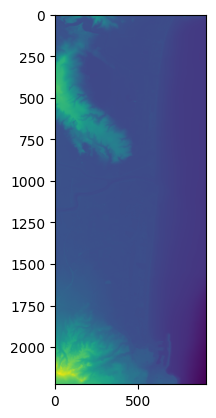

In [39]:
plt.imshow(deformed_topography)
# plt.gca().invert_yaxis()
# plt.axis('off')
# plt.savefig("mask.png", dpi=100, bbox_inches='tight', transparent=True)



In [41]:
max_height

<class 'netCDF4.Variable'>
int16 max_height(lat, lon)
    long_name: Maximum wave amplitude
    units: meters
    missing_value: 32767
    _FillValue: 32767
    scale_factor: 0.0015259022
    add_offset: 50.000763
unlimited dimensions: 
current shape = (2224, 912)
filling on

In [ ]:
mask = (topography > 0) & (max_height > deformed_topography)
flow_depth[mask] = (max_height - deformed_topography)[mask]

IndexError: arrays used as indices must be of integer (or boolean) type

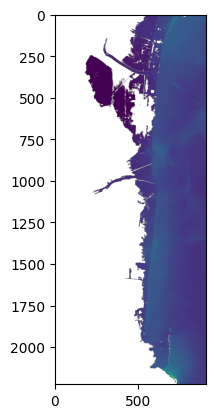

In [37]:
plt.imshow(max_height[:,:])

In [ ]:
max_height[:,:].data > 0

In [35]:
mask = np.logical_and(max_height[:,:].mask, max_height[:,:].data > 0)

In [ ]:
plt.imshow(mask)

In [ ]:
n_pois

In [ ]:
from keras import layers, models, Input, regularizers
reg = 1e-5

def get_model():
    # Encoder
    encoder = models.Sequential([
        Input(shape=(n_pois,481,1)),
        layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1), use_bias=False, kernel_regularizer=regularizers.l2(reg)),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 2)),
        layers.Conv2D(64, (3, 5), activation='relu', strides=(1, 1), use_bias=False, kernel_regularizer=regularizers.l2(reg)),
        layers.MaxPooling2D(pool_size=(3, 5), strides=(2, 3)),
        layers.Conv2D(128, (3, 5), activation='relu', strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=regularizers.l2(reg)),
        layers.MaxPooling2D(pool_size=(3, 5), strides=(2, 3)),
        layers.Conv2D(32, (1, 1), activation='relu', strides=(1, 1), use_bias=True, kernel_regularizer=regularizers.l2(reg)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(16, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(reg))
    ])
    
    # Decoder
    decoder = models.Sequential([
        layers.Dense(32, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(reg)),
        layers.Dense(418908, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(reg))
    ])
    
    # Complete Model
    model = models.Sequential([encoder, decoder])
    
    return model

# Instantiate and build the model
model = get_model()
model.summary()

In [ ]:
model.layers[0].summary()

In [ ]:
model(eta).shape

In [ ]:

batch_size = 10  # Adjust to your requirements
dataset_size = 164
epochs = 10
steps_per_epoch = int(dataset_size/batch_size)

# Create dataset from generator
dataset = tf.data.Dataset.from_generator(
        generator=reader.generator,
        output_signature=(
                tf.TensorSpec(shape=(n_pois, 481), dtype=tf.int32),
                tf.TensorSpec(shape=(reader.topo_mask.sum()), dtype=tf.int32)
        )
).cache().shuffle(buffer_size=dataset_size)
batched_dataset = dataset.batch(batch_size)#.prefetch(tf.data.AUTOTUNE)

# Define the model (already done in previous steps)
model = get_model()

# Compile the model with a loss function and optimizer
model.compile(optimizer='adam', 
              loss="mse",  # Adjust as per your task (e.g., binary crossentropy or MSE)
              metrics=['mse'])

# Fit the model
model.fit(batched_dataset, epochs=epochs)#, steps_per_epoch=steps_per_epoch)


In [ ]:
%tensorboard generated/emulator_20250117_094513/logs/fit

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [6]:
from src.data_reader import DataReader


TOPO_FILE = '/home/ebr/data/PTHA2020_runs_UMA/Catania/C_CT.grd'
TOPO_MASK = '/home/ebr/data/PTHA2020_runs_UMA/Catania/ct_mask.txt'
TRAIN_SCENARIOS ="/home/ebr/data/PTHA2020_runs_UMA/train_591/scenarios.txt"
TRAIN_DIR = '/home/ebr/data/PTHA2020_runs_UMA/train_591'

pois = range(30,45)
n_pois = len(pois)

reader = DataReader(
    scenarios_file=TRAIN_SCENARIOS,
    pois=pois,
    datadir=DATA_DIR,
    topofile=TOPOFILE,
    topo_mask_file=TOPO_MASK,
    shuffle_on_load=False, 
    reload=False
)

In [ ]:
for eta, flow_depth, scenario in reader.generator():
    print(flow_depth)
    break

In [ ]:
plt.imshow(eta[1:15,1:100])
plt.colorbar()